## Main Quest - 의료영상 U-Net 용종검출

### 목표
- 위내시경 이미지에 용종을 표시한 데이터를 이용해 모델을 구성하고, 용종을 찾는 Segmentation 모델 생성
- 의료이미지 특성상 수가 적은 데이터셋을 활용하기 위한 Data augmentation 진행
- Encoder-Decoder Model과 U-net 모델을 구현해 보고, U-Net이 일반 Encoder-Decoder 모델 대비 어느정도 성능향상이 되는지 확인
- U-Net에 pretrained encoder를 적용하여 성능개선

### 1. 데이터 수집 및 Visualization
- Giana Dataset에서 제공하는 용종 내시경 데이터셋(https://giana.grand-challenge.org/Dates/)
- 데이터셋 전처리 및 시각화

In [1]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.6.0


### 1.1 Split dataset into train data and test data

- 데이터셋을 학습용과 테스트용으로 분리
- 데이터셋의 이미지와 라벨은 각각 train, train_labels 디렉토리에 분리
- 쌍을 이루는 이미지와 라벨의 파일명은 동일
- 사이킷런의 train_test_split을 이용해서 학습(train) 데이터와 테스트(test) 데이터를 분리

In [2]:
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

In [3]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [4]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [5]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


### 1.2 Visualization

- 데이터셋 이미지 샘플 중 5개 살펴보기

> 라벨은 클래스 값이 아니라, 입력이미지와 동일한 X-Y 사이즈를 가지고 용종 부위만 표시된 1채널짜리 이미지임을 확인. 즉, Semantic Segmentation

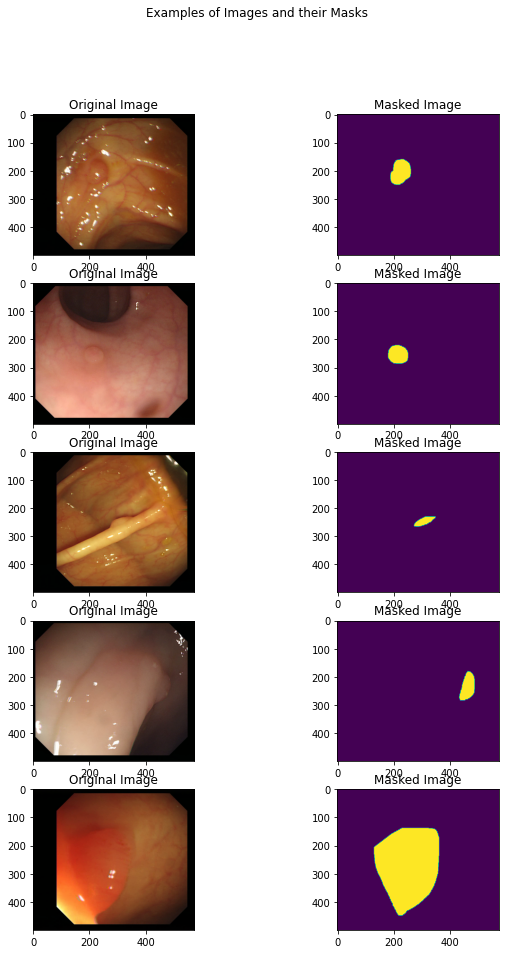

In [6]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

## 2. Data pipeline and Preprocessing

### 2.1 Set up hyper-parameters

- 공통적으로 적용될 하이퍼파라미터 미리 셋팅

In [7]:
# Set hyperparameters

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 4
max_epochs = 10

### 2.2 tf.data를 활용한 입력 파이프라인 설계

- tf.data.Dataset을 이용해 데이터셋 구축, 배치처리
- 다양한 함수를 map에 적용하여 Data Augmentation을 함께 구현(데이터 갯수가 부족하므로)
> tf.data에 대한 텐서플로우 튜토리얼에 소개된 내용  
이미지와 레이블 모두 파일 이름에서 파일의 바이트를 읽음 => 바이트를 이미지 형식으로 디코딩 => _augment 함수를 통한 이미지 변환 적용 => 데이터를 섞고, 데이터를 반복하여 학습
- Processing each pathname: 실제 이미지 데이터를 로드하는 함수를 구현
    - byte 형태로 데이터를 로드하고, bmp로 디코딩  
    - 디코딩이 완료된 image를 scale과 size를 조절

In [8]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

##### 2.3.1 Data augmentation - Shifting the image

- 로드한 이미지를 기반으로 이미지의 위치를 적절히 이동(shift)시키는 함수  
- 입력이미지와 라벨의 쌍을 동일하게 shift시켜주어야

In [9]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

##### 2.3.2 Data augmentation - Flipping the image randomly

- 로드한 이미지를 기반으로 이미지를 flip하는 함수  
- 50%의 확률로 좌우반전만 구현, 상하반전은 적용X 

In [10]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

##### 2.3.3 Data augmentation Assembling

- 구현한 Augmentation용 함수를 이용해 Data augmentation에 사용하는 _augment() 함수를 구성  
- resize, hue_delta 적용

In [11]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

### 2.3 Set up train and test datasets

- tf.data.Dataset을 이용하여 데이터셋 배치구성, 셔플링 등을 구현
- 만들어온 augmentation도 함께 적용  
- Train dataset에서만 Data augmentation을 진행하게 설정

In [12]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [13]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

### 2.4 Plot some train data

- 학습 데이터를 확인  
     - data augmentation 효과도 잘 적용되었는지 확인

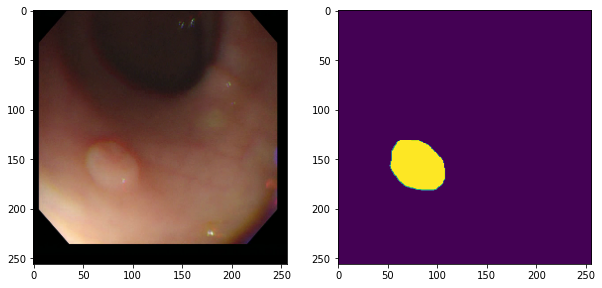

In [14]:
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

## 3. Build the model
-  3개의 네트워크 만들어 성능 비교
    - Encoder-Decoder 스타일의 네트워크  
    - U-Net
    - VGG

### 3.1 Encoder-Decoder architecture

- Encoder를 이용해 우리가 가진 Train data를 작은 차원의 공간에 압축하는 방식으로 동작
- Decoder는 Encoder가 압축한 데이터들을 우리가 원하는 label 데이터와 같도록 재생성
- 이렇게 생성된 데이터와 label 간의 차이가 작아지도록 Encoder와 Decoder의 파라미터들이 End-to-End로 학습


In [15]:
# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs: [batch_size, 16, 16, 512]

In [16]:
# Encoder 제대로 만들어졌는지 확인

bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
print(bottleneck.shape)   # (batch_size, 16, 16, 512) 이 나오는지 확인

(4, 16, 16, 512)


In [17]:
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

In [18]:
# decoder 제대로 만들어졌는지 확인

predictions = decoder(bottleneck)
print(predictions.shape)    # (batch_size, 256, 256, 1) 이 나오는지 확인

(4, 256, 256, 1)


### 3.1.1 Create a encoder-decoder model

In [19]:
ed_model = tf.keras.Sequential()

ed_model.add(encoder)
ed_model.add(decoder)

In [20]:
print('select the Encoder-Decoder model')
model_ed = ed_model
checkpoint_dir_ed =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

select the Encoder-Decoder model


##### metrics과 loss functions 정의하기

- 사용할 loss function
    - binary cross entropy  
    - dice_loss
- Cross-entropy loss와 Dice loss를 같이 사용해 meanIoU를 더 올리도록 학습

In [21]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [22]:
# Dice Loss가 최대화되도록
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [23]:
# 새로운 Loss function을 사용하기위해서
# 기존에 사용하였던 Binary crossentropy loss와
# 새로 구현한 Dice loss를 더하는 방식으로 구성

def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [24]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

##### compile

In [25]:
model_ed.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions_ed = model_ed(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions_ed.shape)

(4, 256, 256, 1)


In [26]:
model_ed.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (4, 16, 16, 512)          4693056   
_________________________________________________________________
decoder (Sequential)         (4, 256, 256, 1)          2354913   
Total params: 7,047,969
Trainable params: 7,042,209
Non-trainable params: 5,760
_________________________________________________________________


##### Callbacks

- Callback 함수 이용  
   - ModelCheckpoint callback 함수:  
     모델 학습간 특정 feature를 모니터링하다 기준점을 넘으면 모델 파라미터를 저장
   - LearningRateScheduler callback 함수:  
     학습을 진행하며, 주어진 인자의 값을 이용해 Learning rate를 조절
   - cos_decay:  
     cos 함수의 모양으로 Learning rate를 조절해 주는 learning rate decay 구현

In [27]:
if not os.path.isdir(checkpoint_dir_ed):
    os.makedirs(checkpoint_dir_ed)

cp_callback_ed = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir_ed,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [28]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

### 3.2 U-Net architecture

- padding을 same으로 두고 Encoder, Decoder간 대응하는 레이어의 사이즈를 동일하게 가져가기  
    - 크게 성능에 영향을 주지 않으면서도 구현이 용이할 뿐더러 이후 모델의 추가개선을 더욱 쉽게 만들어 주는 장점

### 3.2.1 Model subclassing을 활용한 구현

- U-Net은 Encoder-Decoder 구조와는 달리 해당 레이어의 outputs이 바로 다음 레이어의 inputs이 되지 않아 tf.keras.Sequential()을 쓸 수가 없음  
    - Sequential 구조가 아닌 네트워크를 만들 때 쓸 수 있는 API: tf.keras functional API  
- U-Net 구현을 위해 Model subclassing 방식을 사용하여, tf.keras.Model 클래스를 상속하여 구현

In [29]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [30]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder


class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [31]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

### 3.2.2 Create a U-Net model

In [32]:
unet_model = UNet()

In [33]:
print('select the U-Net model')
model_unet = unet_model
checkpoint_dir_unet =os.path.join(DATASET_PATH,'train_ckpt/unet_model')

select the U-Net model


##### compile

In [34]:
model_unet.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions_unet = model_unet(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions_unet.shape)

(4, 256, 256, 1)


In [35]:
model_unet.summary()

Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block (EncoderBlock) multiple                  76416     
_________________________________________________________________
encoder_block_1 (EncoderBloc multiple                  444288    
_________________________________________________________________
encoder_block_2 (EncoderBloc multiple                  1773312   
_________________________________________________________________
encoder_block_3 (EncoderBloc multiple                  7085568   
_________________________________________________________________
conv_block_4 (ConvBlock)     multiple                  28326912  
_________________________________________________________________
decoder_block (DecoderBlock) multiple                  18882048  
_________________________________________________________________
decoder_block_1 (DecoderBloc multiple                  354278

In [36]:
if not os.path.isdir(checkpoint_dir_unet):
    os.makedirs(checkpoint_dir_unet)

cp_callback_unet = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir_unet,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [37]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

## 3.3 VGG16 
##### pretrained model을 활용한 U-Net 모델 구성
- Encoder를 pretrained 모델로 변경하는 작업  
     - VGG16을 활용
       * VGG16 모델의 레이어 구성을 확인
       * U-Net이란 Encoder와 Decoder 사이의 대응되는 레이어간의 skip connection이 특징인 모델로 Encoder를 pretrained model로 바꿔주려면 Encoder로 활용할 모델의 레이어 구성 확인
       
       
##### VGG16을 Encoder로 활용하여 개선한 새로운 모델 클래스
- 내부에서 새로운 모델(vgg16_act)을 만들었는데,  
- 이것은 VGG16의 특정 레이어 출력을 가져와 Decoder와 연결하기 위한 것  
- 기존 UNet 클래스와 비교하면, encoder 레이어가 없어지고 vgg16_act 모델의 출력이 그 역할을 대신하고 있음

In [38]:
class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2], 
                                               layer_outputs[5], 
                                               layer_outputs[9], 
                                               layer_outputs[13], 
                                               layer_outputs[17]])


        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):

        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs) 

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)

        return outputs

In [39]:
vgg16 = Vgg16UNet()

In [40]:
model_vgg = vgg16
checkpoint_dir_vgg =os.path.join(DATASET_PATH,'train_ckpt/vgg_model')

In [41]:
model_vgg.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions_vgg = model_vgg(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions_vgg.shape)

(4, 256, 256, 1)


In [42]:
model_vgg.summary()

Model: "vgg16u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
model (Functional)           [(None, 256, 256, 64), (N 14714688  
_________________________________________________________________
conv_block_5 (ConvBlock)     multiple                  0 (unused)
_________________________________________________________________
decoder_block_4 (DecoderBloc multiple                  9444864   
_________________________________________________________________
decoder_block_5 (DecoderBloc multiple                  2952960   
_________________________________________________________________
decoder_block_6 (DecoderBloc multiple                  739200    
_________________________________________________________________
decoder_block_7 (DecoderBloc multiple                  1

In [43]:
if not os.path.isdir(checkpoint_dir_vgg):
    os.makedirs(checkpoint_dir_vgg)

cp_callback_vgg = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir_vgg,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [44]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

## 4. Training

- model.fit() 함수 이용  
- Train dataset과 Test dataset등을 이용해 학습을 진행
- 학습 데이터의 갯수가 부족하기때문에 Test dataset을 Validation dataset으로 사용

In [45]:
history_ed = model_ed.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback_ed, lr_callback]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
60/60 [==============================] - 11s 108ms/step - loss: 1.0323 - dice_loss: 0.7586 - val_loss: 2.1287 - val_dice_loss: 0.9277
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
60/60 [==============================] - 8s 103ms/step - loss: 0.9326 - dice_loss: 0.7245 - val_loss: 1.0666 - val_dice_loss: 0.7829
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
60/60 [==============================] - 8s 104ms/step - loss: 0.9269 - dice_loss: 0.7239 - val_loss: 1.0350 - val_dice_loss: 0.7314
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
60/60 [==============================] - 8s 104ms/step - loss: 0.8850 - dice_loss: 0.6923 - val_loss: 0.9907 - val_di

In [46]:
history_unet = model_unet.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback_unet, lr_callback]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
60/60 [==============================] - 37s 478ms/step - loss: 0.9918 - dice_loss: 0.7358 - val_loss: 871.9365 - val_dice_loss: 0.9018
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
60/60 [==============================] - 29s 470ms/step - loss: 0.9156 - dice_loss: 0.7188 - val_loss: 0.9940 - val_dice_loss: 0.7410
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
60/60 [==============================] - 30s 475ms/step - loss: 0.8985 - dice_loss: 0.7065 - val_loss: 1.0784 - val_dice_loss: 0.8636
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
60/60 [==============================] - 29s 466ms/step - loss: 0.8905 - dice_loss: 0.7015 - val_loss: 1.0405 - v

In [47]:
history_vgg = model_vgg.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback_vgg, lr_callback]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
60/60 [==============================] - 25s 307ms/step - loss: 0.9866 - dice_loss: 0.7414 - val_loss: 27.9454 - val_dice_loss: 0.8783
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
60/60 [==============================] - 20s 307ms/step - loss: 0.9082 - dice_loss: 0.7164 - val_loss: 2.8668 - val_dice_loss: 0.8089
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
60/60 [==============================] - 19s 301ms/step - loss: 0.8952 - dice_loss: 0.7018 - val_loss: 0.8910 - val_dice_loss: 0.6462
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
60/60 [==============================] - 19s 299ms/step - loss: 0.8843 - dice_loss: 0.6958 - val_loss: 1.0986 - va

## 5. Results - Visualization

In [48]:
# Test Dataset 내에 데이터들을 얼만큼 잘 맞추었는지 확인
## Define print function
def print_images(model):
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

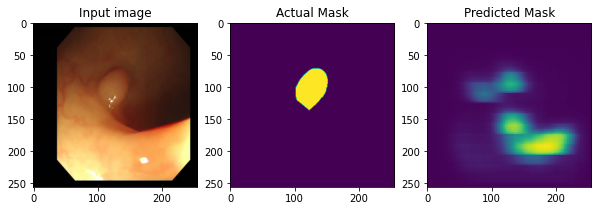

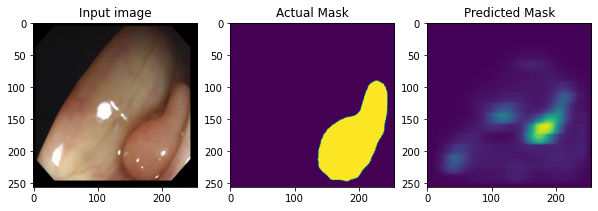

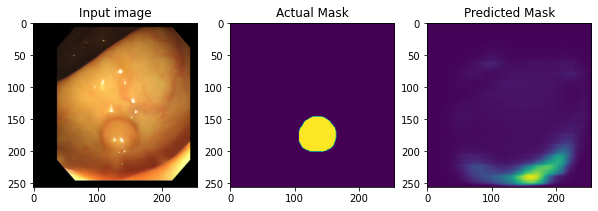

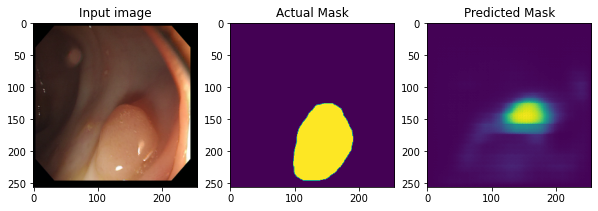

In [49]:
# 학습후 Encoder-Decoder 이미지
print_images(model_ed)

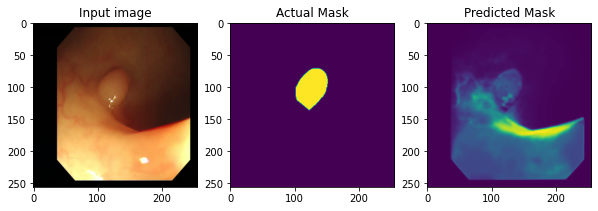

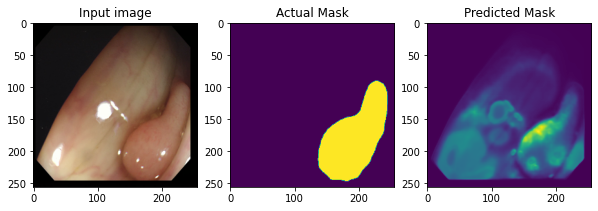

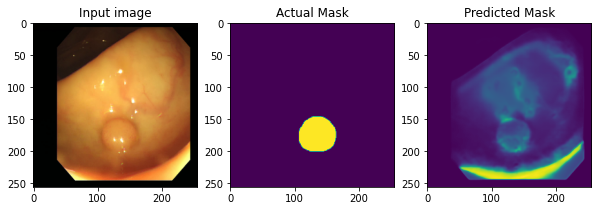

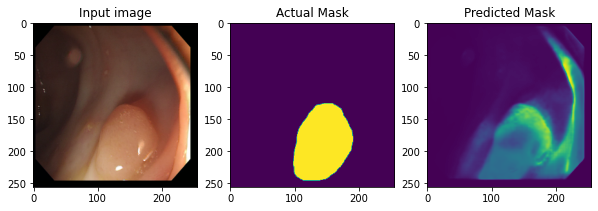

In [50]:
# 학습후 U-Net 이미지
print_images(model_unet)

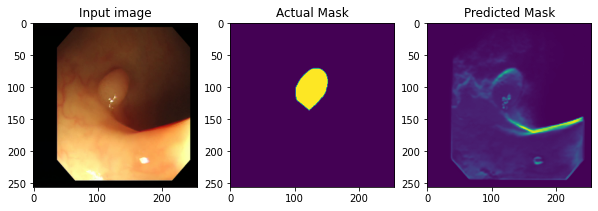

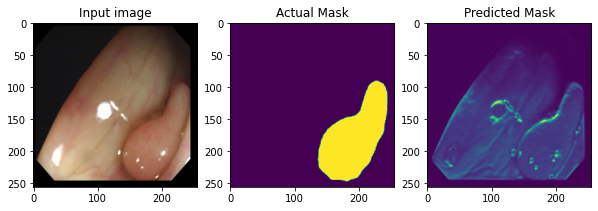

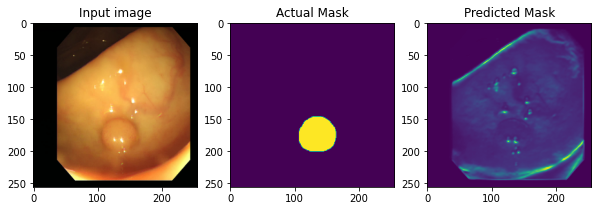

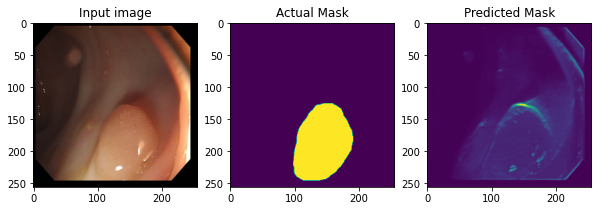

In [51]:
# 학습후 VGG16 이미지
print_images(model_vgg)

##### Plot the loss

- 저장된 학습 진행과정(history)을 시각화

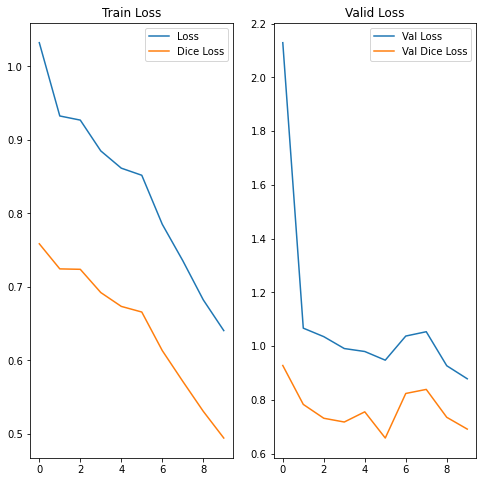

In [52]:
# Encoder-Decoder
dice_loss = history_ed.history['dice_loss']
loss = history_ed.history['loss']
val_dice_loss = history_ed.history['val_dice_loss']
val_loss = history_ed.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

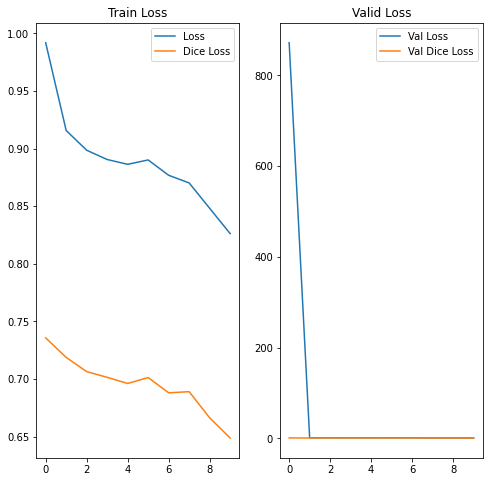

In [53]:
# U-Net
dice_loss = history_unet.history['dice_loss']
loss = history_unet.history['loss']
val_dice_loss = history_unet.history['val_dice_loss']
val_loss = history_unet.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

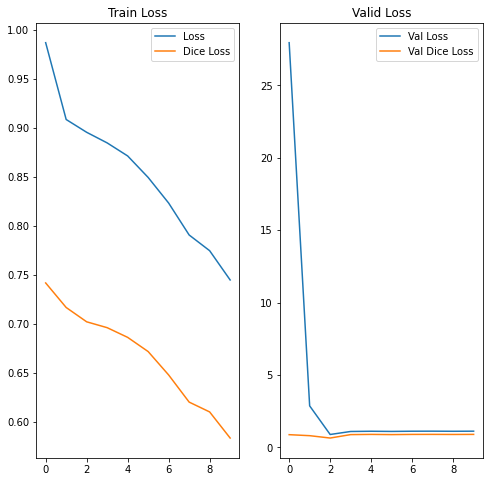

In [54]:
# VGG16
dice_loss = history_vgg.history['dice_loss']
loss = history_vgg.history['loss']
val_dice_loss = history_vgg.history['val_dice_loss']
val_loss = history_vgg.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

## 6. 모델 성능 비교분석

- Encoder-Decoder 모델, U-Net 모델, VGG16(Pretrained U-Net) 모델에 대해 학습 진행과정, 정량/정성적 테스트 결과를 포함한 비교분석  

##### Restore the latest checkpoint

- 저장된 모델의 가중치를 불러온다.
- ed_ckpt나 unet_ckpt에 담긴 것이 미리 학습시킨 모델로, 직접 학습시킨 모델은 train_ckpt에 있으며. 원하는 모델을 불러와 사용

In [55]:
# 원하는 모델을 불러올 수 있도록 적절히 주석을 처리
checkpoint_dir_ed = os.path.join(DATASET_PATH, 'train_ckpt/ed_model')
checkpoint_dir_unet = os.path.join(DATASET_PATH, 'train_ckpt/unet_model')
checkpoint_dir_vgg = os.path.join(DATASET_PATH, 'train_ckpt/vgg_model')

# restoring the latest checkpoint in checkpoint_dir
model_ed.load_weights(checkpoint_dir_ed)
model_unet.load_weights(checkpoint_dir_unet)
model_vgg.load_weights(checkpoint_dir_vgg)

#### Evaluate the test dataset

- 불러온 가중치를 이용해서 모델을 평가  
    - meanIoU를 metric으로 하여 정량적으로 평가해 볼 수 있고,  
    - 실제 생성된 segmentation 이미지를 분석해서 정성적으로 평가해 볼 수 있음  
    * meanIoU란 각 이미지의 IoU 값을 평균 낸 값으로, IoU는 segmentation 모델을 정량적으로 평가하는데 좋은 metric이 됨

In [56]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [69]:
# 테스트 데이터셋을 불러와서 meanIoU 값 구하기
# 이 값은 훈련시킨 모델에 대한 정량적 성능 metric으로 활용

mean_ed = []
mean_unet = []
mean_vgg = []

for images, labels in test_dataset:
    # encoder-decoder
    predictions_ed = model_ed(images, training=False)
    m_ed = mean_iou(labels, predictions_ed)
    mean_ed.append(m_ed)
    
    # unet
    predictions_unet = model_unet(images, training=False)
    m_unet = mean_iou(labels, predictions_unet)
    mean_unet.append(m_unet)
    
    # vgg
    predictions_vgg = model_vgg(images, training=False)
    m_vgg = mean_iou(labels, predictions_vgg)
    mean_vgg.append(m_vgg)

# encoder-decoder
mean_ed = np.array(mean_ed)
mean_ed = np.mean(mean_ed)
print("mean_iou_ed: {}".format(mean_ed))
    
# unet
mean_unet = np.array(mean_unet)
mean_unet = np.mean(mean_unet)
print("mean_iou_unet: {}".format(mean_unet))

# vgg
mean_vgg = np.array(mean_vgg)
mean_vgg = np.mean(mean_vgg)
print("mean_iou_vgg: {}".format(mean_vgg))

mean_iou_ed: 0.5202579455944135
mean_iou_unet: 0.48641245027504887
mean_iou_vgg: 0.49209663719639607


In [70]:
# Test Dataset 내에 데이터들을 얼만큼 잘 맞추었는지 확인
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        #모델 예측
        predictions_ed = model_ed(test_images, training=False)
        predictions_unet = model_unet(test_images, training=False)
        predictions_vgg = model_vgg(test_images, training=False)
        
        # 데이터 시각화
        for i in range(batch_size):
            plt.figure(figsize=(15, 5))
                       
            # 입력
            plt.subplot(1, 5, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            # 실제
            plt.subplot(1, 5, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")
            
            # Encoder-Decoder 모델 예측
            plt.subplot(1, 5, 3)
            plt.imshow(predictions_ed[i, :, :, 0])
            plt.title("E-D Predicted Mask")
            
            # U-Net 모델 예측        
            plt.subplot(1, 5, 4)
            plt.imshow(predictions_unet[i, :, :, 0])
            plt.title("U-Net Predicted Mask")
            
            # VGG16 모델 예측
            plt.subplot(1, 5, 5)
            plt.imshow(predictions_vgg[i, :, :, 0])
            plt.title("VGG Predicted Mask")
            
            plt.show()
            

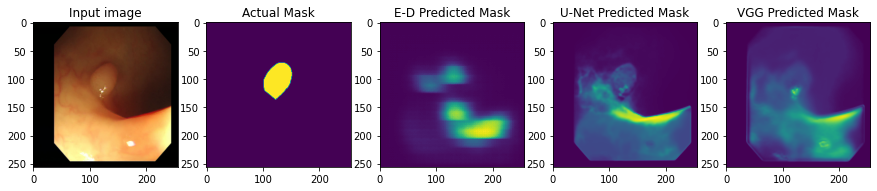

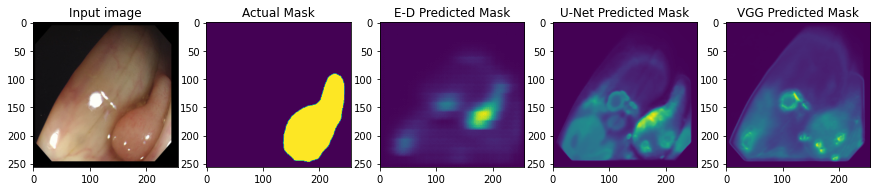

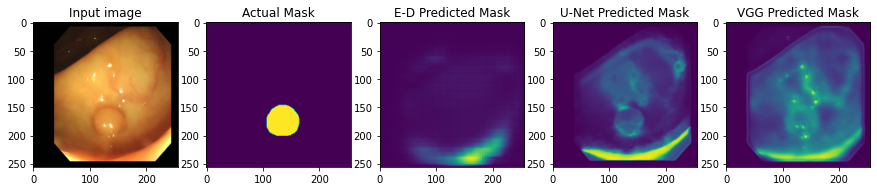

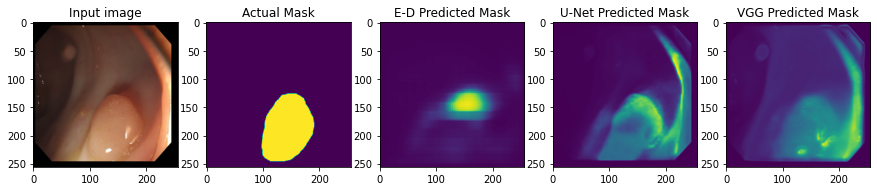

In [72]:
print_images()

### 회고
- 의료영상 데이터에서 용종을 검출하기 위해 3가지 모델에 대한 학습을 진행하여 결과를 분석하였다.
- 예상했던 것보다는 모델이 용종 검출을 잘 하지 못한 결과가 도출되었다. 더 좋은 모델을 위해 성능을 개선할 수 있는 방안 모색도 필요하다는 생각이 들었다. 